# Transformer 모델을 활용한 Neural Machine Translation(기계 번역) 실습

Transformer을 직접 구현한다. 구현한 모델을 바탕으로 Multi30k 데이터셋을 활용하여 독일어를 영어로 번역하는 작업을 수행한다.

## 1. 데이터 전처리 및 Dataset & Dataloader 구성하기

### 1.1. torchdata 설치하기

In [ ]:
!pip install folium==0.2.1

In [ ]:
!pip install torchdata==0.4.0

### 1.2. Multi30k 불러오기

In [3]:
from torchtext.datasets import Multi30k

train, valid, test = Multi30k()

### 1.3. spaCy Tokenizer를 이용하여 영어 Vocab, 독일어 Vocab 구성하기

In [ ]:
# Tokenizer를 위한 데이터 다운로드
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [5]:
import spacy

en_tokenizer = spacy.load('en_core_web_sm')
de_tokenizer = spacy.load('de_core_news_sm')

In [6]:
def tokenize(tokenizer, text):
    return [ token.text for token in tokenizer.tokenizer(text)]

In [7]:
# tokenize 테스트
tokenize(en_tokenizer, 'I translate English into German.')
tokenize(de_tokenizer, 'Ich übersetze Englisch ins Deutsche.')

['Ich', 'übersetze', 'Englisch', 'ins', 'Deutsche', '.']

In [8]:
from functools import partial
from torchtext.vocab import build_vocab_from_iterator

In [9]:
en_vocab = build_vocab_from_iterator(map(partial(tokenize, en_tokenizer), [eng for _, eng in train]), min_freq=2, specials=['<pad>', '<unk>', '<sos>', '<eos>'])
de_vocab = build_vocab_from_iterator(map(partial(tokenize, de_tokenizer), [de for de , _ in train ]), min_freq=2, specials=['<pad>', '<unk>', '<sos>', '<eos>'])

In [10]:
len(en_vocab), len(de_vocab)

(6191, 8014)

In [11]:
en_vocab['<unk>'], de_vocab['<unk>']

(1, 1)

In [12]:
print(en_vocab.get_itos()[:10])
print(de_vocab.get_itos()[:10])

['<pad>', '<unk>', '<sos>', '<eos>', 'a', '.', 'A', 'in', 'the', 'on']
['<pad>', '<unk>', '<sos>', '<eos>', '.', 'Ein', 'einem', 'in', ',', 'und']


### 1.4. 전처리 클래스

In [13]:
class Language:
    pad_token_id = 0
    unk_token_id = 1
    sos_token_id = 2
    eos_token_id = 3

    def __init__(self, src_tokenizer, tgt_tokenizer, src_token2id, tgt_token2id, src_id2token, tgt_id2token):
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer

        self.src_token2id = src_token2id
        self.tgt_token2id = tgt_token2id

        self.src_id2token = src_id2token
        self.tgt_id2token = tgt_id2token

    def src_encode(self, src_text):
        source_sentence = [ self.src_token2id.get(token.text, Language.unk_token_id) for token in self.src_tokenizer.tokenizer(src_text) ]
        return source_sentence
    
    def tgt_encode(self, tgt_text):
        target_sentence = [self.tgt_token2id['<sos>']] \
        + [ self.tgt_token2id.get(token.text, Language.unk_token_id) for token in self.tgt_tokenizer.tokenizer(tgt_text) ] \
        + [ self.tgt_token2id['<eos>'] ]
        return target_sentence
    
    def src_decode(self, ids):
        sentence = list(map(lambda x: self.src_id2token[x], ids))
        return " ".join(sentence)

    def tgt_decode(self, ids):
        sentence = list(map(lambda x: self.tgt_id2token[x], ids))[1:-1]
        return " ".join(sentence)

### 1.5. Dataset 구현

In [14]:
from torch.utils.data import Dataset, DataLoader

In [15]:
class MultiDataset(Dataset):
    def __init__(self, data, language):
        self.data = data
        self.language = language
        self.sentences = self.preprocess()

    def preprocess(self):
        # dataset 안에 길이가 0인 문장이 존재한다. 
        sentences = [ (self.language.src_encode(de), self.language.tgt_encode(eng)) 
                      for de, eng in self.data if len(eng) > 0 and len(de) > 0]

        return sentences

    def src_max_len(self):
        return max([len(src) for src, tgt in self.sentences])

    def tgt_max_len(self):
        return max([len(tgt) for src, tgt in self.sentences])

    def __getitem__(self, idx):
        return self.sentences[idx]

    def __len__(self):
        return len(self.sentences)

In [16]:
language = Language(de_tokenizer, en_tokenizer, de_vocab.get_stoi(), en_vocab.get_stoi(), de_vocab.get_itos(), en_vocab.get_itos())

In [ ]:
train_dataset = MultiDataset(train, language)
valid_dataset = MultiDataset(valid, language)
test_dataset = MultiDataset(test, language)

In [18]:
# TEST
print(train_dataset[0])
print(valid_dataset[0])
print(test_dataset[0])

([21, 85, 257, 31, 87, 22, 94, 7, 16, 112, 7910, 3209, 4], [2, 19, 25, 15, 1169, 808, 17, 57, 84, 336, 1339, 5, 3])
([14, 38, 24, 243, 2744, 1, 11, 20, 892], [2, 6, 39, 13, 36, 17, 1667, 2541, 342, 4, 282, 3])
([5, 12, 10, 6, 178, 108, 8, 16, 78, 1, 4], [2, 6, 12, 7, 28, 91, 68, 2670, 20, 122, 5, 3])


### 1.6. DataLoader 구성


#### collate_fn

하나의 배치안에 존재하는 sequence의 길이를 pad token을 이용하여 맞춰준다.

In [19]:
import torch
from torch.nn.utils.rnn import pad_sequence

In [20]:
def collate_fn(batch_samples):
    pad_token_id = Language.pad_token_id

    src_sentences = pad_sequence([torch.tensor(src).long() for src, _ in batch_samples], batch_first=True, padding_value=pad_token_id)
    tgt_sentences = pad_sequence([torch.tensor(tgt).long() for _, tgt in batch_samples], batch_first=True, padding_value=pad_token_id)

    return src_sentences, tgt_sentences

#### batch_sampler

비슷한 길이의 sequence가 하나의 배치로 구성될 있도록 index를 반환해준다.

In [21]:
import random

In [22]:
def batch_sampling(sequence_lengths, batch_size):
    '''
    sequence_length: (source 길이, target 길이)가 담긴 리스트이다.
    batch_size: batch 크기
    '''

    seq_lens = [(i, seq_len, tgt_len) for i,(seq_len, tgt_len) in enumerate(sequence_lengths)]
    seq_lens = sorted(seq_lens, key=lambda x: x[1])
    seq_lens = [sample[0] for sample in seq_lens]
    sample_indices = [ seq_lens[i:i+batch_size] for i in range(0,len(seq_lens), batch_size)]

    random.shuffle(sample_indices) # 모델이 길이에 편향되지 않도록 섞는다.

    return sample_indices

#### DataLoader

In [23]:
def make_dataloader(dataset, batch_size):
    sequence_lengths = list(map(lambda x: (len(x[0]), len(x[1])), dataset))
    batch_sampler = batch_sampling(sequence_lengths, batch_size)

    return DataLoader(dataset, collate_fn=collate_fn, batch_sampler=batch_sampler)

In [24]:
### TEST
train_loader = make_dataloader(train_dataset, 5)

for src, tgt in train_loader:
    print(src)
    print(tgt)
    break

tensor([[   5,   12,   10,    6,    1,   30,   22,  120,    7,   13,   38,   24,
           11,   26,  324, 2063,    1,    7,   16,  112,   16,  827,    4],
        [  14,   17,   11,    6,  395,    7,    6,  178,  264,   39,   20,  217,
            9,  110,   24,   13,   17,    7,    6,   47,  122,  926,    4],
        [   5,   12,   10,  142,    8,   16,   20,   92,  140,    7,    6,   10,
          416,   10,  368,  976,   10,   26,  146,  104,  516,   39,    4],
        [   5,   12,    8,   16,   10,   26,   90,   19,   36,   73,   64,    8,
          284,   15,  445, 2301,    7,    6, 1048,  103,   25,  604,    4],
        [   5,   12,   10,    1,    9,  558,  266,  149,   58,   18, 6057,    8,
           37,   18,  844,   11,   16,    1, 1502,  152,    1,   32,    4]])
tensor([[   2,    6,   12,   21,    4,  101,  466,   15,   10,   37,    7,    8,
          101,  765,    4,   39,   13, 5744,    9,   70, 1487,   84,    8, 2784,
            5,    3,    0,    0,    0,    0],
      

## 2. Transformer 구현하기

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### 2.1. Scaled Dot-Product Attention 구현

$A(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$

Attention은 3가지를 입력 요소로 받는다.
* Q: queries - shape: (batch_size, n_heads, seq_len, head_dim)
* K: keys - shape: (batch_size, n_heads, seq_len, head_dim)
* V: values - shape: (batch_size, n_heads, seq_len, head_dim)

masking 처리를 위해 mask를 사용하기도 한다.
* mask: padding을 처리하거나 masked multi-head attention을 위해 다음 요소를 masking처리할 때 사용한다.

Scaled Dot-Product Attention의 결과로 2가지를 반환한다.
* $softmax(\frac{QK^T}{\sqrt{d_k}})V$ 계산 결과
* attention distribution

In [26]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, mask=None):
        d_k = torch.tensor(Q.shape[-1])
        QK_T = torch.matmul(Q, K.transpose(-1,-2)) # (batch_size, n_heads, seq_len, seq_len)
        scaled = QK_T / torch.sqrt(d_k)
        if mask is not None:
            scaled.masked_fill_(mask==0, -1e14) # 0인 부분 masking 처리, 아주 작은 값을 주어 attention score를 작게 만든다.
        attention_distribution = F.softmax(scaled, dim=-1) # (batch_size, n_heads, seq_len, seq_len)
        output = torch.matmul(attention_distribution, V) # (batch_size, n_heads, seq_len, hidden_dim)

        return output, attention_distribution

### 2.2. Multi-Head Attention

* 하이퍼 파라미터
    * n_heads: head 수
    * hidden_dim = input, query, key, value dimension
        * $d_{model}$, $d_k$. $d_v$로 구분하지 않고 모두 하나로 맞춰주었다.
    * dropout: DropOut 비율

* 입력 요소
    * Q: queries - shape: (batch_size, seq_len, input_dim)
    * K: Keys - shape: (batch_size, seq_len, input_dim)
    * V: values - shape: (batch_size, seq_len, input_dim)

masking 처리를 위해 mask를 사용하기도 한다.
* mask: padding을 처리하거나 masked multi-head attention을 위해 다음 요소를 masking처리할 때 사용한다.

Multi-Head Attention의 결과로 2가지를 반환한다.
* $softmax(\frac{QK^T}{\sqrt{d_k}})V$ 계산 결과
* attention distribution

In [27]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, hidden_dim, dropout=0.5):
        super(MultiHeadAttention, self).__init__()

        assert hidden_dim % n_heads == 0

        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads

        self.W_Q = nn.Linear(hidden_dim, hidden_dim)
        self.W_K = nn.Linear(hidden_dim, hidden_dim)
        self.W_V = nn.Linear(hidden_dim, hidden_dim)

        self.attention = ScaledDotProductAttention()

        self.W_O = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V, mask=None):

        batch_size = Q.shape[0]

        Q = self.W_Q(Q) # (batch_size, seq_len, hidden_dim)
        K = self.W_K(K) # (batch_size, seq_len, hidden_dim)
        V = self.W_V(V) # (batch_size, seq_len, hidden_dim)

        # Multi-Head
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1,2) # (batch_size, n_heads, seq_len, head_dim)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1,2) # (batch_size, n_heads, seq_len, head_dim)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1,2) # (batch_size, n_heads, seq_len, head_dim)

        output, score = self.attention(Q,K,V, mask)

        output = self.dropout(output)

        output = output.transpose(1,2).contiguous().view(batch_size, -1, self.n_heads * self.head_dim) # (batch_size, seq_len, hidden_dim)
        output = self.W_O(output) # (batch_size, seq_len, input_dim)

        return output, score

### 2.3. Position-Wise FeedForward Network

* 하이퍼 파라미터
    * hidden_dim
    * ff_dim: 피드포워드 네트워크 은닉층 dimension
    * dropout: DropOut 비율

In [28]:
class PositionWiseFFNN(nn.Module):
    def __init__(self, hidden_dim, ff_dim, dropout=0.5):
        super(PositionWiseFFNN, self).__init__()

        self.layer1 = nn.Linear(hidden_dim, ff_dim)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(ff_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)

        return x

### 2.4. Postional Encoding



In [29]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, hidden_dim, device):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, hidden_dim).to(device)
        pos = torch.arange(max_len).view(-1,1)
        index = torch.arange(0, hidden_dim, step=2)

        self.encoding[:,::2] = torch.sin(pos/10000**(index/hidden_dim)).to(device)
        self.encoding[:,1::2] = torch.cos(pos/10000**(index/hidden_dim)).to(device)

    def forward(self, x):
        seq_len = x.shape[1] # (batch_size, seq_len, hidden_dim)
        return x + self.encoding[:seq_len,:]

### 2.5. Encoder

#### EncoderBlock

* 하이퍼 파라미터
    * n_heads: head 수
    * hidden_dim = input, query, key, value dimension
    * ff_dim: 피드포워드 네트워크 은닉층 dimension
    * dropout: DropOut 비율

* 입력 요소
    * src: (batch_size, seq_len, hidden_dim)
    * src_mask: source mask (padding 처리 용도)

* sub-layer
    * Multi-Head Attention
    * Position-Wise FeedForward Neural Network

In [31]:
class EncoderBlock(nn.Module):
    def __init__(self, n_heads, hidden_dim, ff_dim, dropout=0.5):
        super(EncoderBlock, self).__init__()

        self.attention = MultiHeadAttention(n_heads, hidden_dim, dropout)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)

        self.ffnn = PositionWiseFFNN(hidden_dim, ff_dim, dropout)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        src_, score = self.attention(src, src, src, src_mask)
        src = self.layer_norm1(src + self.dropout(src_))

        src_ = self.ffnn(src)
        src = self.layer_norm2(src + self.dropout(src_))

        return src, score

#### Encoder

* 하이퍼 파라미터
    * n_layers: Encoder Block 수
    * src_vocab_size: source vocab size
    * max_len: maximun sequence length
    * n_heads: head 수
    * hidden_dim = input, query, key, value dimension
    * ff_dim: 피드포워드 네트워크 은닉층 dimension
    * dropout: DropOut 비율

In [32]:
class Encoder(nn.Module):
    def __init__(self, n_layers, src_vocab_size, max_len, n_heads, hidden_dim, ff_dim, device,dropout=0.5):
        super(Encoder, self).__init__()

        self.embedding = nn.Embedding(src_vocab_size, hidden_dim)
        self.encoding = PositionalEncoding(max_len, hidden_dim, device)

        self.layers = nn.ModuleList([EncoderBlock(n_heads, hidden_dim, ff_dim, dropout) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        src = self.embedding(src) # (batch_size, seq_len, hidden_dim)
        src = self.encoding(src) # (batch_size, seq_len, hidden_dim)

        for encoder_block in self.layers:
            src, score = encoder_block(src, src_mask)

        return src, score

### 2.6. Decoder



#### Decoder Block

* 하이퍼 파라미터
    * n_heads: head 수
    * hidden_dim = input, query, key, value dimension
    * ff_dim: 피드포워드 네트워크 은닉층 dimension
    * dropout: DropOut 비율

* 입력 요소
    * src: (batch_size, seq_len, hidden_dim)
    * tgt: (batch_size, seq_len, hidden_dim)
    * src_mask: source mask (padding 처리 용도)
    * tgt_mask: target mask (padding, 다음 단어 처리 용도)

* sub-layer
    * Masked Multi-Head Attention
    * Encoder-Decoder Attention
    * Position-Wise FeedForward Neural Network

In [33]:
class DecoderBlock(nn.Module):
    def __init__(self, n_heads, hidden_dim, ff_dim, dropout=0.5):
        super(DecoderBlock, self).__init__()

        self.masked_attention = MultiHeadAttention(n_heads, hidden_dim, dropout)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)

        self.attention = MultiHeadAttention(n_heads, hidden_dim, dropout)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

        self.ffnn = PositionWiseFFNN(hidden_dim, ff_dim)
        self.layer_norm3 = nn.LayerNorm(hidden_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt, src_mask, tgt_mask):

        tgt_, _ = self.masked_attention(tgt, tgt, tgt, tgt_mask)
        tgt = self.layer_norm1(tgt + self.dropout(tgt_))

        tgt_, score = self.attention(tgt, src, src, src_mask)
        tgt = self.layer_norm2(tgt + self.dropout(tgt_))

        tgt_ = self.ffnn(tgt)
        tgt = self.layer_norm3(tgt + self.dropout(tgt_))

        return tgt, score

#### Decoder

* 하이퍼 파라미터
    * n_layers: Decoder Block 수
    * tgt_vocab_size: target vocab size
    * max_len: maximun sequence length
    * n_heads: head 수
    * hidden_dim = input, query, key, value dimension
    * ff_dim: 피드포워드 네트워크 은닉층 dimension
    * dropout: DropOut 비율

In [34]:
class Decoder(nn.Module):
    def __init__(self, n_layers, tgt_vocab_size, max_len, n_heads, hidden_dim, ff_dim, device, dropout=0.5):
        super(Decoder, self).__init__()

        self.embedding = nn.Embedding(tgt_vocab_size, hidden_dim)
        self.encoding = PositionalEncoding(max_len, hidden_dim, device)

        self.layers = nn.ModuleList([ DecoderBlock(n_heads, hidden_dim, ff_dim, dropout) for _ in range(n_layers)])

        self.output = nn.Linear(hidden_dim, tgt_vocab_size)

    def forward(self, tgt, src, tgt_mask, src_mask):
        tgt = self.embedding(tgt) # (batch_size, seq_len, hidden_dim)
        tgt = self.encoding(tgt)

        for decoder_block in self.layers:
            tgt, score = decoder_block(src, tgt, src_mask, tgt_mask)

        output = self.output(tgt)

        return output, score

### 2.7. Transformer

* 하이퍼 파라미터
    * encoder_layers: Encoder Block 수
    * src_vocab_size: target vocab size
    * src_max_len: maximun sequence length

    * decoder_layers: Decoder Block 수
    * tgt_vocab_size: target vocab size
    * tgt_max_len: maximun sequence length

    * src_pad_idx: source padding index
    * tgt_pad_idx: target padding index

    * n_heads: head 수
    * hidden_dim = input, query, key, value dimension
    * ff_dim: 피드포워드 네트워크 은닉층 dimension
    * dropout: DropOut 비율

In [35]:
class Transformer(nn.Module):
    def __init__(self, encoder_layers, src_vocab_size, src_max_len,
                       decoder_layers, tgt_vocab_size, tgt_max_len,
                       src_pad_idx, tgt_pad_idx,
                       n_heads, hidden_dim, ff_dim, device, dropout=0.5
                 ):
        
        super(Transformer, self).__init__()
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        self.device = device
        self.encoder = Encoder(encoder_layers, src_vocab_size, src_max_len, n_heads, hidden_dim, ff_dim, device, dropout)
        self.decoder = Decoder(decoder_layers, tgt_vocab_size, tgt_max_len, n_heads, hidden_dim, ff_dim, device ,dropout)

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        return src_mask

    def make_tgt_mask(self, tgt):
        tgt_mask1 = (tgt != self.tgt_pad_idx).unsqueeze(1).unsqueeze(2)

        tgt_len = tgt.size()[1]
        tgt_mask2 = torch.tril(torch.ones((tgt_len, tgt_len),device=self.device)).bool()

        tgt_mask = tgt_mask1 & tgt_mask2 

        return tgt_mask

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)

        enc_src, _ = self.encoder(src, src_mask)

        output, attention = self.decoder(tgt, enc_src, tgt_mask, src_mask)

        return output, attention

## 3. 모델 학습

### 3.1. Model Configure 클래스

In [36]:
class Config:
    src_max_len = max(train_dataset.src_max_len(), valid_dataset.src_max_len(), test_dataset.src_max_len())
    tgt_max_len = max(train_dataset.tgt_max_len(), valid_dataset.tgt_max_len(), test_dataset.tgt_max_len())

    encoder_layers = 3
    decoder_layers = 3

    src_vocab_size = len(de_vocab)
    tgt_vocab_size = len(en_vocab)

    pad_token_id = Language.pad_token_id

    num_heads = 8
    hidden_dim = 256
    ff_dim = 512

    dropout = 0.1

    def __getitem__(self, name):
        assert hasattr(self, name), "해당 속성이 존재하지 않습니다."
        return getattr(self, name)

In [37]:
config = Config()

config['tgt_max_len']

43

### 3.2. Train

In [38]:
from tqdm.notebook import tqdm

In [39]:
def train(model, optimizer, dataloader, pad_index, device):
    model.to(device)

    bar = tqdm(dataloader, desc='train')
    total_loss = 0.

    criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

    for i, (src, tgt) in enumerate(bar, start=1):
        src = src.to(device)
        tgt = tgt.to(device)
        out, score = model(src, tgt)
        loss = criterion(out[:,:-1,:].transpose(1,2), tgt[:,1:])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        current_loss = total_loss / i
        bar.set_description(f"Train-loss:{current_loss:.4f}")

### 3.3. Evaluate

In [40]:
def evaluate(model, dataloader, pad_index, device, mode):
    model.to(device)

    bar = tqdm(dataloader, desc=mode)
    total_loss = 0.
    loss_avg = 0.

    criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

    for i, (src, tgt) in enumerate(bar, start=1):
        src = src.to(device)
        tgt = tgt.to(device)
        out, score = model(src, tgt)
        loss = criterion(out[:,:-1,:].transpose(1,2), tgt[:,1:])

        total_loss += loss.item()
        current_loss = total_loss / i
        loss_avg = current_loss
        bar.set_description(f"{mode}-loss:{current_loss:.4f}")
    
    return loss_avg

### 3.4. 학습

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer(config['encoder_layers'], config['src_vocab_size'], config['src_max_len'], config['decoder_layers'], config['tgt_vocab_size'], config['tgt_max_len'],
                    config['pad_token_id'], config['pad_token_id'], config['num_heads'],config['hidden_dim'], config['ff_dim'], device, config['dropout'])

optimizer = optim.Adam(model.parameters())

In [42]:
batch_size = 128
num_epoch = 7

train_loader = make_dataloader(train_dataset, batch_size)
valid_loader = make_dataloader(valid_dataset, batch_size)

for epoch in range(num_epoch):
    train(model, optimizer, train_loader,Language.pad_token_id, device)
    val_loss = evaluate(model, valid_loader, Language.pad_token_id, device, 'valid')
    print("="*60)
    print(f"END OF EPOCH:{epoch+1} | VALID LOSS: {val_loss:.4f}")
    print("="*60)

train:   0%|          | 0/227 [00:00<?, ?it/s]

valid:   0%|          | 0/8 [00:00<?, ?it/s]

END OF EPOCH:1 | VALID LOSS: 2.7775


train:   0%|          | 0/227 [00:00<?, ?it/s]

valid:   0%|          | 0/8 [00:00<?, ?it/s]

END OF EPOCH:2 | VALID LOSS: 2.2580


train:   0%|          | 0/227 [00:00<?, ?it/s]

valid:   0%|          | 0/8 [00:00<?, ?it/s]

END OF EPOCH:3 | VALID LOSS: 2.0215


train:   0%|          | 0/227 [00:00<?, ?it/s]

valid:   0%|          | 0/8 [00:00<?, ?it/s]

END OF EPOCH:4 | VALID LOSS: 1.9323


train:   0%|          | 0/227 [00:00<?, ?it/s]

valid:   0%|          | 0/8 [00:00<?, ?it/s]

END OF EPOCH:5 | VALID LOSS: 1.8975


train:   0%|          | 0/227 [00:00<?, ?it/s]

valid:   0%|          | 0/8 [00:00<?, ?it/s]

END OF EPOCH:6 | VALID LOSS: 1.9202


train:   0%|          | 0/227 [00:00<?, ?it/s]

valid:   0%|          | 0/8 [00:00<?, ?it/s]

END OF EPOCH:7 | VALID LOSS: 1.9215


### 3.5. TEST

In [43]:
test_loader = make_dataloader(test_dataset, batch_size)

print("="*60)
test_loss = evaluate(model, test_loader, Language.pad_token_id, device, 'test')
print(f"END OF TEST | TEST LOSS: {test_loss:.4f}")
print("="*60)

test:   0%|          | 0/8 [00:00<?, ?it/s]

END OF TEST | TEST LOSS: 1.9744


### 3.6. 번역 테스트

In [44]:
def translate(sentence, language, model, device, max_len=50):
    model.eval()
    model = model.to(device)

    src_tokens = torch.tensor(language.src_encode(sentence)).unsqueeze(0).long().to(device)
    src_mask = model.make_src_mask(src_tokens)

    with torch.no_grad():
        enc_src, _ = model.encoder(src_tokens, src_mask)
    
    tgt_indices = [language.sos_token_id]

    for i in range(max_len):
        tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).long().to(device)
        tgt_mask = model.make_tgt_mask(tgt_tensor)

        with torch.no_grad():
            output, score = model.decoder(tgt_tensor, enc_src, tgt_mask, src_mask)

        pred_token = output[:,-1,:].argmax(dim=-1).item()
        tgt_indices.append(pred_token)

        if pred_token == language.eos_token_id:
            break
    return language.tgt_decode(tgt_indices), score

In [45]:
test_text = [text for text in test]

In [46]:
test_text[1]

('Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.',
 'A Boston Terrier is running on lush green grass in front of a white fence.')

In [47]:
translated, score = translate("Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.", language, model, device)

translated

'A Boston dog runs in front of a white fence in front of a white fence .'

In [48]:
translated, score = translate("Eine Mutter und ihre jungen Mädchen genießen einen Tag", language, model, device)

translated

'A mom and her young girls enjoying a day .'

* 문장: Eine Mutter und ihre jungen Mädchen genießen einen Tag
* papago 번역: A mother and her young girls enjoy a day
* 예측 결과: A mom and her young girl enjoying a day .



In [49]:
translated, score = translate("Ein Mann, der ins Ausland reist", language, model, device)

translated

'A man walking down the water .'

* 문장: Ein Mann, der ins Ausland reist
* papago 번역: a man traveling abroad
* 예측 결과: A man walking down the water .

In [50]:
translated, score = translate("Der Mann kocht und hört Musik.", language, model, device)

translated

'The man is cooking and playing music .'

* 문장: Der Mann kocht und hört Musik.
* papago 번역: The man cooks and listens to music.
* 예측 결과: The man is cooking and playing music .

### 3.7. Attention 시각화

In [70]:
!pip show matplotlib

Name: matplotlib
Version: 3.2.2
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /usr/local/lib/python3.7/dist-packages
Requires: pyparsing, python-dateutil, numpy, kiwisolver, cycler
Required-by: yellowbrick, seaborn, scikit-image, pycocotools, prophet, plotnine, pandas-profiling, mlxtend, mizani, missingno, matplotlib-venn, keras-vis, imgaug, fastai, descartes, daft, arviz


In [111]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(score, language, source, translated, n_heads=8, n_rows=4, n_cols=2):
    assert n_heads == (n_rows * n_cols)

    fig, axes = plt.subplots(4,2, figsize=(20,20))

    src_tokens = language.src_encode(source)
    src_tokens = [language.src_id2token[token] for token in src_tokens]

    tgt_tokens = language.tgt_encode(translated)
    tgt_tokens = [language.tgt_id2token[token] for token in tgt_tokens][1:]

    # score: (batch_size, n_heads, tgt_len, src_len)
    score = score.squeeze(0).detach().cpu()

    for i in range(n_rows):
        for j in range(n_cols):
            c = axes[i,j].pcolor(score[i].transpose(-2,-1).numpy(),cmap='GnBu')
            fig.colorbar(c,ax=axes[i,j])

            axes[i,j].set_xticks(np.arange(0.5,len(tgt_tokens),1))
            axes[i,j].set_yticks(np.arange(0.5,len(src_tokens),1))

            axes[i,j].set_xticklabels(tgt_tokens, rotation=45)
            axes[i,j].set_yticklabels(src_tokens)


In [112]:
translated, score = translate("Eine Mutter und ihre jungen Mädchen genießen einen Tag", language, model, device)

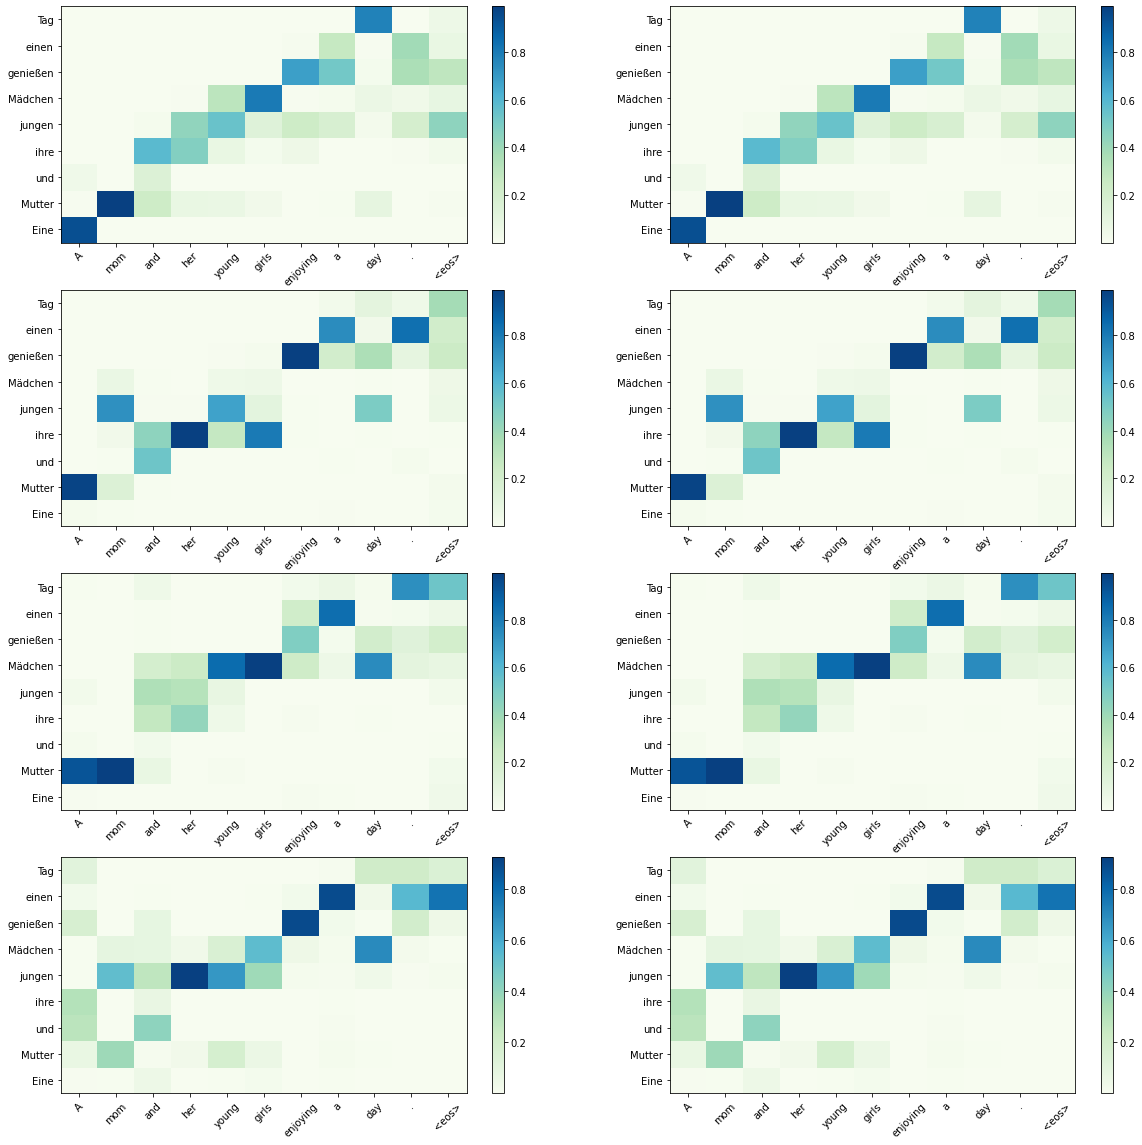

In [113]:
visualize_attention(score, language,"Eine Mutter und ihre jungen Mädchen genießen einen Tag", translated)